In [23]:
from math import sqrt
from math import sin
from math import cos
from math import tan
from math import acos
from math import fabs
from math import exp
from math import log
from math import log10
import numpy as np 
import math as math 
import matplotlib.pyplot as plt 

import scipy
from scipy import special
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import LSODA

from scipy import optimize
from scipy.optimize import curve_fit
from scipy import integrate

In [40]:
Mbh = 2e33*6.5e9
G = 6.67e-8
c = 3e10
rg = G*Mbh/c**2
D = 16.4e6*3.08e18

In [25]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! this part is about calculation of metric functions !!!!!!!!!!!!!!!!!!!!!!!!!!!!

def potential(phi,const):
    return(-const[0]**2/2*phi**2+const[1]/4*phi**4, -const[0]**2*phi+const[1]*phi**3)

def eq3(dMeff,Meff,U,dnu,nu,phi,ksi,a,b):
    const = [a, b]
    V, dV = potential(phi,const)
    return((1-ksi*dnu/2)*(-ksi*dMeff - Meff)/(ksi*(1-ksi*Meff))-(5*U**2)/(2*ksi**4*phi*(1+phi))+
            2*U/(ksi**3*(1+phi)) - 0.5*dnu**2+1/ksi*dnu - 2*(2*phi/3*(2*V-(1+phi)*dV)+V)/(ksi**4*(1+phi)*(1-ksi*Meff)))

def dnu_func(ksi,phi,Meff,nu,U,a,b):
    const = [a, b]
    V, dV = potential(phi,const)
    return(-(ksi-(U*(8*phi+3*U/ksi)/(4*phi*(1+phi))+ksi)*(1-
        ksi*Meff) - V/(ksi*(1+phi)))/(ksi**2*(1-ksi*Meff)*(1+U/(2*ksi*(1+phi)))))
def dMeff_func(ksi,phi,Meff,dnu,U,a,b):
    const = [a, b]
    V, dV = potential(phi,const)
    return((((1-Meff*ksi)*(3*U**2/(4*phi)-2*ksi*U)+
    Meff*ksi**3*(1+phi) - V)/(ksi**4*(1+phi+U/(2*ksi)))-Meff/ksi+(1-
    Meff*ksi)/(ksi**2*(1+phi+U/(2*ksi)))*(U*Meff/(2*(1-ksi*Meff))-U/2*dnu-
    U**2/(2*phi*ksi**2)+2*U/ksi) - 
    2*phi/3*(2*V-(1+phi)*dV)/(ksi**4*(1+phi+U/(2*ksi))))/(1-U/(2*ksi*(1+phi+U/(2*ksi)))))

In [26]:
# function for field equations
def equations(y,ksi, a, b):
    const = [a, b]
    V, dV = potential(y[0],const)
    dphi = -y[3]/ksi**2
    dnu = -(ksi-(y[3]*(8*y[0]+3*y[3]/ksi)/(4*y[0]*(1+y[0]))+ksi)*(1-
            ksi*y[1]) - V/(ksi*(1+y[0])))/(ksi**2*(1-ksi*y[1])*(1+y[3]/(2*ksi*(1+y[0]))))
    dMeff = (((1-y[1]*ksi)*(3*y[3]**2/(4*y[0])-2*ksi*y[3])+
            y[1]*ksi**3*(1+y[0]) - V)/(ksi**4*(1+y[0]+y[3]/(2*ksi)))-y[1]/ksi+(1-
            y[1]*ksi)/(ksi**2*(1+y[0]+y[3]/(2*ksi)))*(y[3]*y[1]/(2*(1-ksi*y[1]))-y[3]/2*dnu-
            y[3]**2/(2*y[0]*ksi**2)+2*y[3]/ksi) - 
            2*y[0]/3*(2*V-(1+y[0])*dV)/(ksi**4*(1+y[0]+y[3]/(2*ksi))))/(1-y[3]/(2*ksi*(1+y[0]+y[3]/(2*ksi))))
    d2nu = ((1-ksi*y[4]/2)*(-ksi*dMeff - y[1])/(ksi*(1-ksi*y[1]))-(5*y[3]**2)/(2*ksi**4*y[0]*(1+y[0]))+
            2*y[3]/(ksi**3*(1+y[0])) - 0.5*dnu**2 + 1/ksi*dnu  - 2*(2*y[0]/3*(2*V-(1+y[0])*dV)+V)/(ksi**4*(1+y[0])*(1-ksi*y[1])))
    dU = ((y[3]/2*(ksi*dMeff+y[1]))/(1-ksi*y[1])- 2*y[0]/3*(2*V-(1+y[0])*dV)/(ksi**2*(1-ksi*y[1]))-
           y[3]*dnu/2-y[3]**2/(ksi**2*2*y[0])+2*y[3]/ksi)
    return[dphi, dMeff,  dnu,  dU, d2nu]

In [ ]:
y0 = np.zeros(5)

# initial values for dimensionless variables

y0[0] = 4

y0[1] = 1.0
y0[2] = -1e-70
    
a = -1e-10

b = 1e-11

ksi=np.arange(0.002,0.86,1e-4)

mphi = (-4*a*y0[0]-10*b*y0[0]**4-16*b*y0[0]**3)/3*(c**2/(2*G*Mbh))**2*2
# mphi = (-4*a*(c**2/(2*G*Msol))**2)**0.5

y0[3] = (ksi[0]**2*y0[0]/3*exp(-mphi*((2*G*Mbh)/(ksi[0]*c**2))) 
          + ksi[0]*y0[0]*mphi*exp(-mphi*((2*G*Mbh)/(ksi[0]*c**2)))/3*2*G*Mbh/c**2)
y0[4] = -1e-70
  
    
# solution of field equations
sol = odeint(equations, y0, ksi, args = (a, b))

phi=sol[:,0]
Meff=sol[:,1]
nu = sol[:,2]

U = sol[:,3]
dnu = sol[:,4]

l=0
for i in range(len(ksi)):
    if exp(nu[i])!=1:
        l+=1
l+=1

expnu = np.zeros(l)

explam = np.zeros(l)
ksi1 = np.zeros(l)
i = 0
while(i<l):
    expnu[i] = exp(nu[i])
    explam[i] = 1/(1-Meff[i]*ksi[i])
    ksi1[i] = ksi[i]
    i+=1
    
# approximation for metric functions

def func8(x, a, b, c,d,e,f):
    return(a*x**5+b*x**4+c*x**3+d*x**2+e*x+f)


popt1, pcov1 = curve_fit(func8, ksi1, expnu)

popt2, pcov2 = curve_fit(func8, ksi1, 1/explam)

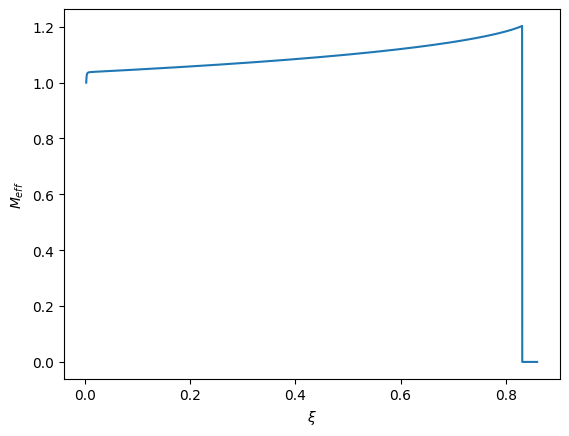

In [29]:
# example of solution for Meff
# a sharp break in the function corresponds to the crossing of the event horizon
fig, ax = plt.subplots()
plt.plot(ksi,Meff)
ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$M_{eff}$")
plt.show()

In [30]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! this part is about calculation of disc spectrum !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [31]:
# equation for last stable orbit
def equation_isco(r,E,L,gphirr,gtrr,gphir,gtr,gphi,gt):
    return(E**2*gphirr+L**2*gtrr+gtrr*gphi+2*gphir*gtr+gt*gphirr)

In [32]:
def spectr(ksi,phi,Meff,nu,U,expnu,explam):
    u = 6600

    dnu = np.zeros(u)
    dMeff = np.zeros(u)
    Veff = np.zeros(u)
    r = np.zeros(u)

    gt = np.zeros(u)
    gphi = np.zeros(u)
    gtr = np.zeros(u)
    gphir = np.zeros(u)
    gtrr = np.zeros(u)
    gphirr = np.zeros(u)

    omega = np.zeros(u)
    L = np.zeros(u)
    E = np.zeros(u)
    omegar = np.zeros(u)
    Lr = np.zeros(u)
    dMeff = np.zeros(u)
    detg = np.zeros(u)
    dMeff = np.zeros(u)

# accretion mass flow

    M0dot =  6.34e24

    for i in range(u):
        dnu[i] = dnu_func(ksi[i], phi[i], Meff[i], nu[i], U[i],a,b)
        r[i] = 1/ksi[i]*2*G*Mbh/c**2
        gt[i] = -expnu[i]*c**2
        gphi[i] = r[i]**2
        gtr[i] = -expnu[i]*c**2*dnu[i]*(c**2/(-2*G*Mbh))*ksi[i]**2
        gphir[i] = 2*r[i]
        dMeff[i] = dMeff_func(ksi[i], phi[i], Meff[i], dnu[i], U[i],a,b)
        gtrr[i] = (-expnu[i]*c**2*dnu[i]**2 - expnu[i]*c**2*eq3(dMeff[i],Meff[i],U[i],dnu[i],nu[i],phi[i],ksi[i],a,b))*ksi[i]**4*c**4/(4*G**2*Mbh**2)
        gphirr[i] = 2
        omega[i] = sqrt(-gtr[i]/gphir[i])
        E[i] = -gt[i]/sqrt(-gt[i]-gphi[i]*omega[i]**2)
        L[i] = gphi[i]*omega[i]/sqrt(-gt[i]-gphi[i]*omega[i]**2)
        omegar[i] = 0.5*(-gtrr[i]/gphir[i]+gtr[i]*gphirr[i]/gphir[i]**2)/sqrt(-gtr[i]/gphir[i])
        Lr[i] = (gphir[i]*omega[i]/sqrt(-gt[i]-gphi[i]*omega[i]**2)+gphi[i]*omegar[i]/sqrt(-gt[i]-gphi[i]*omega[i]**2)-
                 0.5*gphi[i]*omega[i]*(-gtr[i]-gphir[i]*omega[i]**2-gphi[i]*2*omega[i]*omegar[i])/(-gt[i]-gphi[i]*omega[i]**2)**1.5)

        detg[i] = c*expnu[i]**0.5*explam[i]**0.5*r[i]**2
        Veff[i] = equation_isco(r[i],E[i],L[i],gphirr[i],gtrr[i],gphir[i],gtr[i],gphi[i],gt[i])
    
    i = 1
    integr = 0
    j=0
    riso = 0

    for i in range(u-1):
        if (Veff[i-1]<0)&(Veff[i]>0):
            riso = r[i-1]
            j = i-1
        
    i = j

    Eiso = E[j]/c

    F = np.zeros(j+1)
    r1 = np.zeros(j+1)
    zplus1 = np.zeros(j+1)



    i1 = i
    print(i)

    
    while (i1>=0):
        zplus1[i1] = c/(-gt[i1]-omega[i1]**2*gphi[i1])**0.5
        i1-=1
    
    while(i>=0):
        integr = integr + (E[i]-omega[i]*L[i])*Lr[i]*(r[i-1]-r[i])*r[i]
        F[i] = c**3*M0dot*(-omegar[i])/(4*math.pi*detg[i]*(E[i]-omega[i]*L[i])**2)*integr
        r1[i] = r[i]/(G*Mbh/c**2)
        i-=1

    return(r1, F, 1 - Eiso, riso, zplus1,omega)

2911


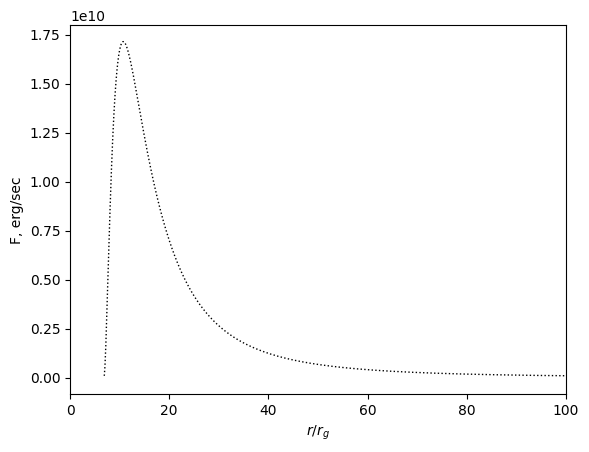

In [33]:
r1, F, eff, riso, zplus1, omega = spectr(ksi,phi,Meff,nu,U,expnu,explam)

fig, ax = plt.subplots()

plt.plot(r1, F, 'black',linestyle='dotted', linewidth=1, label='PPN')

plt.xlim(0, 100)     

ax.set_xlabel(r"$r/r_{g}$")
ax.set_ylabel(r"F, erg/sec")
plt.show()

In [34]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!! this part is about calculation of black hole shadow !!!!!!!!!!!!!!!!!!!!!!!!!

In [35]:
# turning point function
def turning(u,b,rg,popt1,popt2):
    u1 = u*2*rg
    return(1/b**2*func8(u1, *popt2)/func8(u1, *popt1)-u**2*func8(u1, *popt2))

In [36]:
# left part of equation for black hole shadow
def part_left(b,r,rg,r_s,ut,popt1,popt2):
    u = 0
    du = 1/r/1000
    f1 = 0
    p=1
    if (1/b**2-u**2*(1-2*rg*u))<0:
        p=0
    
    xx = np.zeros(1000)
    yy = np.zeros(1000)
    i=1
    f11 = 0
    while(i<1000)&(p!=0):
        yy[i-1] = 1/sqrt((1/b**2*func8(xx[i-1]*2*rg, *popt2)/func8(xx[i-1]*2*rg, *popt1)-xx[i-1]**2*func8(xx[i-1]*2*rg, *popt2)))
        xx[i]=xx[i-1]+du
        i+=1
    xx1 = np.zeros(1000)
    yy1 = np.zeros(1000)
    if ut==1:
        i = 1
        du = (1/r-1/r_s)/1000
        u = 1/r
        xx1[0]=1/r_s
        while(i<1000):
            yy1[i-1] = 1/sqrt((1/b**2*func8(xx1[i-1]*2*rg, *popt2)/func8(xx1[i-1]*2*rg, *popt1)-xx1[i-1]**2*func8(xx1[i-1]*2*rg, *popt2)))
            xx1[i]=xx1[i-1]+du
            u+=du
            i+=1
        f11 = scipy.integrate.simpson(yy1, x=xx1)
    f1 = scipy.integrate.simpson(yy, x=xx)
    return(f1+f11)

In [37]:
# right part of equation for black hole shadow
def part_right(phi,incl,nim):
    f2 = nim*math.pi - acos(sin(phi)*tan(incl)/sqrt(1+sin(phi)**2*tan(incl)**2))
    return(f2)

In [38]:
# function for image of accretion disc
def image(r, incl, popt1,popt2):
    x = np.zeros(5000)
    ut = np.zeros(5000)
    x[0] = 1
    i = 1
    ii = 0
    iii = 0
    jj = 0
    for jj in range(4999):
        x[i] = x[i-1] + 0.0003*r
        j = 0
        du = 1/(2*rg)/10000
        u = du
        while j<9999:
            if (turning(u,x[i-1],rg,popt1,popt2)<0)&(turning(u-du,x[i-1],rg,popt1,popt2)>0):
                ut[i-1] = u-du
                j = 10000
            u+=du
            j+=1
        if i%1000==0:
            print('i = ', i, '   ', x[i-1]/rg,'  ',1/ut[i-1]/rg)
        if (ut[i-1]>0) & (ut[i-1]>1/(r)):
            ii+=1
        if (ut[i-1]>1/(r))|(ut[i-1]<0)|(ut[i-1]==0):
            iii+=1
        if (ut[i-2]==0) & (ut[i-1]>0):
            numb = i-1
        i+=1
            
    y1 = np.zeros(iii+ii)
    x122 = np.zeros(iii+ii)
    
    i = 0
    for i in range(iii):
        y1[i] = part_left(x[i], r, rg, 0, 0,popt1,popt2)
        x122[i] = x[i]
    i = 0
    while i<ii:
        y1[ii+iii-i-1] = part_left(x[i+numb], 1/(ut[i+numb]), rg, r, 1,popt1,popt2)
        x122[iii+ii-i-1] = x[i+numb]
        i+=1
    
    phi1 = np.zeros(1000)
    y2 = np.zeros(1000)
    y22 = np.zeros(1000)
    
    j = 1    
    for j in range(1000):
        y2[j-1] = part_right(phi1[j-1], incl, 1)
        y22[j-1] = part_right(phi1[j-1], incl, 2)
        phi1[j] = phi1[j-1]+math.pi/500
    print(ii+iii)
    return(x122, phi1, y1, y2, y22, ii+iii)


In [ ]:
# Image of accretion disc plotting
fig, ax = plt.subplots()
i = 0

#for first order image
X_1 = []
Y_1 = []
Flux_1 = []
z_1 = []

# last inner stable orbit
xiso_1 = []
yiso_1 = []

xiso_2 = []
yiso_2 = []

# last orbit

xlast_1 = []
ylast_1 = []

xlast_2 = []
ylast_2 = []

#for second order image
X_2 = []
Y_2 = []
Flux_2 = []
z_2 = []

for i in range(10):
    incl = 85*math.pi/180
    dr = (30*rg-riso)/9
    r = riso+i*dr
    i_f = 1
    while (i_f<len(F)):
        if (r>=r1[i_f]*rg) & (r<=r1[i_f-1]*rg):
            i_f1 = i_f
            i_f = len(F) + 1
        i_f +=1
    x,phi,yleft,yright1,yright2,count = image(r, incl, popt1,popt2)
    print('step №', i)
    for j in range(1000):
        k = 1
        while k<count:
            if (yleft[k-1]<yright1[j-1])&(yleft[k]>yright1[j-1]):
                # first order image of last inner stable orbit
                if i==0:
                    xiso_1.append(x[k-1]*cos(phi[j-1]))
                    yiso_1.append(x[k-1]*sin(phi[j-1]))
                # first order image of last orbit
                if i==9:
                    xlast_1.append(x[k-1]*cos(phi[j-1]))
                    ylast_1.append(x[k-1]*sin(phi[j-1]))
                X_1.append(x[k-1]*cos(phi[j-1]))
                Y_1.append(x[k-1]*sin(phi[j-1]))
                Flux_1.append(F[i_f1]/((1+omega[i_f1]/c*x[k-1]*sin(incl)*cos(math.pi/500*j))*zplus1[i_f1])**4)
                z_1.append(((1+omega[i_f1]/c*x[k-1]*sin(incl)*cos(math.pi/500*j))*zplus1[i_f1]))
                plt.scatter((x[k-1])*cos(phi[j-1])/D*206265*1e6, (-x[k-1])*sin(phi[j-1])/D*206265*1e6, c = 'blue', s = 1)
                k = count
            k+=1
        k = 1
        while k<count:
            if (yleft[k-1]<yright2[j-1])&(yleft[k]>yright2[j-1]):
                # second order image of last inner stable orbit
                if i==0:
                    xiso_2.append(x[k-1]*cos(phi[j-1]))
                    yiso_2.append(x[k-1]*sin(phi[j-1]))
                # second order image of last orbit
                if i==9:
                    xlast_2.append(x[k-1]*cos(phi[j-1]))
                    ylast_2.append(x[k-1]*sin(phi[j-1]))
                
                X_2.append(x[k-1]*cos(phi[j-1]))
                Y_2.append(x[k-1]*sin(phi[j-1]))
                Flux_2.append(F[i_f1]/((1+omega[i_f1]/c*x[k-1]*sin(incl)*cos(math.pi/500*j))*zplus1[i_f1])**4)
                z_2.append(((1+omega[i_f1]/c*x[k-1]*sin(incl)*cos(math.pi/500*j))*zplus1[i_f1]))
                plt.scatter((x[k-1])*cos(phi[j-1])/D*206265*1e6, (-x[k-1])*sin(phi[j-1])/D*206265*1e6, c = 'blue', s = 1)
                k = count
            k+=1
    
    np.save('x_iso2_4_H_new85.npy', xiso_2)
    np.save('y_iso2_4_H_new85.npy', yiso_2)
    
    np.save('x_iso_4_H_new85.npy', xiso_1)
    np.save('y_iso_4_H_new85.npy', yiso_1)
    np.save('x_last_4_H_new85.npy', xlast_1)
    np.save('y_last_4_H_new85.npy', ylast_1)
# first order image
    np.save('x_4_H_1_new85.npy', X_1)
    np.save('y_4_H_1_new85.npy', Y_1)
    np.save('z_4_H_1_new85.npy', z_1)
    np.save('F_4_H_1_new85.npy', Flux_1)
# second order image
    np.save('x_4_H_2_new85.npy', X_2)
    np.save('y_4_H_2_new85.npy', Y_2)
    np.save('z_4_H_2_new85.npy', z_2)
    np.save('F_4_H_2_new85.npy', Flux_2)
    
    
ax.set_xlabel(r"X, mkarcsec")
ax.set_ylabel(r"Y, mkarcsec")
plt.show()

# Here we are also plotting images of orbits